### Retinex model based stain normalization technique for whole slide image analysis 논문 기반에서 조금 보완 진행해봄
* illumination map의 gradient에서 절대값 제거
* 조정 된 illumination map에 minmax normalization 진행
* Optical density를 구하는 과정에서 normalization을 진행하는 것이 맞을까? (skimage에서 이렇게 진행함, OD 구하는 공식과 다름) -> log(0)을 방지하기 위해 0을 1e-6 값으로 치환하는 대신 RGB값에 전부 1을 더함. 또한 Normalization을 진행하지 않음

In [1]:
import os
import yaml
from pathlib import Path
from PIL import Image
from scipy import linalg
from scipy.ndimage import gaussian_filter

import numpy as np
import skimage
import matplotlib.pyplot as plt
from openslide import OpenSlide

from src.utils import *
from src.wsi_reader import WSIReader
from src.transformer import *

In [2]:
config = load_config()
config

{'dataset_path': '/Users/cmkim/workspace/datasets/TIGER/'}

In [3]:
image = WSIReader(
    path=Path(config["dataset_path"]) / "wsibulk/images" / "119S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "103S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "144S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "111S.tif"
).read_array(
    level=32
)

In [4]:
od_transformer = OpticalDensityScaleTransformer()
od = od_transformer.transform(image)

In [5]:
stain_vector = StainSpecficVector.hed()
stain_vector

array([[0.65 , 0.704, 0.286],
       [0.072, 0.99 , 0.105],
       [0.268, 0.57 , 0.776]])

In [6]:
stains = ColorDeconvolution().separate(od, stain_vector)
stains

array([[[ 0.04771506, -0.00511057,  0.03819856],
        [ 0.04771506, -0.00511057,  0.03819856],
        [ 0.04771506, -0.00511057,  0.03819856],
        ...,
        [ 0.04561674, -0.00908285,  0.04435495],
        [ 0.05265567, -0.01289136,  0.04227603],
        [ 0.05265567, -0.01289136,  0.04227603]],

       [[ 0.04771506, -0.00511057,  0.03819856],
        [ 0.04771506, -0.00511057,  0.03819856],
        [ 0.04771506, -0.00511057,  0.03819856],
        ...,
        [ 0.04561674, -0.00908285,  0.04435495],
        [ 0.05265567, -0.01289136,  0.04227603],
        [ 0.05265567, -0.01289136,  0.04227603]],

       [[ 0.04771506, -0.00511057,  0.03819856],
        [ 0.04771506, -0.00511057,  0.03819856],
        [ 0.04771506, -0.00511057,  0.03819856],
        ...,
        [ 0.04561674, -0.00908285,  0.04435495],
        [ 0.05265567, -0.01289136,  0.04227603],
        [ 0.05265567, -0.01289136,  0.04227603]],

       ...,

       [[ 0.04115414, -0.00777966,  0.04097778],
        [ 0

In [7]:
stains.max(), stains.min()

(np.float64(2.3225896669106056), np.float64(-0.27628120191137956))

### illumination map

In [8]:
# tmap = np.max(stains, axis=2)
tmap = np.mean(stains, axis=2)
tmap

array([[0.02693435, 0.02693435, 0.02693435, ..., 0.02696295, 0.02734678,
        0.02734678],
       [0.02693435, 0.02693435, 0.02693435, ..., 0.02696295, 0.02734678,
        0.02734678],
       [0.02693435, 0.02693435, 0.02693435, ..., 0.02696295, 0.02734678,
        0.02734678],
       ...,
       [0.02478409, 0.02478409, 0.02478409, ..., 0.02696295, 0.02734678,
        0.02734678],
       [0.02844499, 0.02844499, 0.02844499, ..., 0.03026702, 0.03065589,
        0.03065589],
       [0.02625335, 0.02625335, 0.02625335, ..., 0.02696295, 0.02734678,
        0.02734678]], shape=(1356, 1736))

In [9]:
tmap_gradh = np.gradient(tmap, axis=1)
tmap_gradv = np.gradient(tmap, axis=0)

In [10]:
epsilon = 1e-4
sigma = 6

In [11]:
gaussian = gaussian_filter(tmap, sigma=sigma)
gaussian

array([[0.02697035, 0.02697463, 0.02698326, ..., 0.02705522, 0.02706031,
        0.02706295],
       [0.02696981, 0.02697402, 0.02698249, ..., 0.02705522, 0.02706031,
        0.02706295],
       [0.02696876, 0.02697282, 0.02698099, ..., 0.02705522, 0.02706031,
        0.02706295],
       ...,
       [0.0274145 , 0.02740832, 0.02739615, ..., 0.02771756, 0.02771901,
        0.0277198 ],
       [0.02739766, 0.02739165, 0.02737982, ..., 0.02774641, 0.02774784,
        0.02774862],
       [0.02738867, 0.02738275, 0.02737111, ..., 0.02776141, 0.02776282,
        0.0277636 ]], shape=(1356, 1736))

In [12]:
wh = np.sum(gaussian / (gaussian * tmap_gradh + epsilon), axis=1, keepdims=True)
wv = np.sum(gaussian / (gaussian * tmap_gradv + epsilon), axis=0, keepdims=True)

In [13]:
wh, wv

(array([[325496.09569362],
        [187205.45550408],
        [247280.58566326],
        ...,
        [486592.74359889],
        [487879.99365121],
        [486385.28458898]], shape=(1356, 1)),
 array([[ 220953.35733474, -384631.31779784, 1026279.40105017, ...,
          424657.03719968,  405120.14223518,  357406.84521503]],
       shape=(1, 1736)))

In [14]:
tmap_adj = tmap / (wh + wv + epsilon)
tmap_adj

array([[ 4.92897386e-08, -4.55470526e-07,  1.99251656e-08, ...,
         3.59432561e-08,  3.74297465e-08,  4.00449009e-08],
       [ 6.59898790e-08, -1.36427672e-07,  2.21958688e-08, ...,
         4.40670028e-08,  4.61684936e-08,  5.02132995e-08],
       [ 5.75232767e-08, -1.96099069e-07,  2.11488669e-08, ...,
         4.01271566e-08,  4.19171521e-08,  4.52246552e-08],
       ...,
       [ 3.50282297e-08,  2.43073174e-07,  1.63821427e-08, ...,
         2.95889741e-08,  3.06676970e-08,  3.24014146e-08],
       [ 4.01293022e-08,  2.75499782e-07,  1.87859930e-08, ...,
         3.31679946e-08,  3.43290946e-08,  3.62668443e-08],
       [ 3.71156669e-08,  2.58008078e-07,  1.73556940e-08, ...,
         2.95957120e-08,  3.06748335e-08,  3.24093809e-08]],
      shape=(1356, 1736))

In [15]:
tmap_adj = (tmap_adj - np.min(tmap_adj)) / (np.max(tmap_adj) - np.min(tmap_adj))
tmap_adj

array([[0.53537789, 0.53537481, 0.53537771, ..., 0.53537781, 0.53537781,
        0.53537783],
       [0.53537799, 0.53537675, 0.53537772, ..., 0.53537786, 0.53537787,
        0.53537789],
       [0.53537794, 0.53537639, 0.53537772, ..., 0.53537783, 0.53537784,
        0.53537786],
       ...,
       [0.5353778 , 0.53537907, 0.53537769, ..., 0.53537777, 0.53537777,
        0.53537778],
       [0.53537783, 0.53537927, 0.5353777 , ..., 0.53537779, 0.5353778 ,
        0.53537781],
       [0.53537781, 0.53537916, 0.53537769, ..., 0.53537777, 0.53537777,
        0.53537778]], shape=(1356, 1736))

In [16]:
stains_adj = stains * tmap_adj[..., np.newaxis]
stains_adj = stains_adj + stains_adj * (1-tmap_adj[..., np.newaxis])
stains_adj

array([[[ 0.03741464, -0.00400733,  0.02995249],
        [ 0.0374145 , -0.00400732,  0.02995239],
        [ 0.03741463, -0.00400733,  0.02995249],
        ...,
        [ 0.03576928, -0.0071221 ,  0.03477988],
        [ 0.04128869, -0.01010845,  0.03314974],
        [ 0.04128869, -0.01010846,  0.03314975]],

       [[ 0.03741464, -0.00400733,  0.0299525 ],
        [ 0.03741459, -0.00400733,  0.02995245],
        [ 0.03741463, -0.00400733,  0.02995249],
        ...,
        [ 0.03576929, -0.0071221 ,  0.03477988],
        [ 0.0412887 , -0.01010846,  0.03314975],
        [ 0.0412887 , -0.01010846,  0.03314975]],

       [[ 0.03741464, -0.00400733,  0.0299525 ],
        [ 0.03741457, -0.00400733,  0.02995244],
        [ 0.03741463, -0.00400733,  0.02995249],
        ...,
        [ 0.03576929, -0.0071221 ,  0.03477988],
        [ 0.0412887 , -0.01010846,  0.03314975],
        [ 0.0412887 , -0.01010846,  0.03314975]],

       ...,

       [[ 0.03227004, -0.00610024,  0.03213175],
        [ 0

In [17]:
null = np.zeros_like(stains[:, :, 0])

In [23]:
hematoxylin = skimage.color.hed2rgb(np.stack((stains[:, :, 0], null, null), axis=-1))
eosin = skimage.color.hed2rgb(np.stack((null, stains[:, :, 1], null), axis=-1))
dab = skimage.color.hed2rgb(np.stack((null, null, stains[:, :, 2]), axis=-1))

In [24]:
hematoxylin_adj = skimage.color.hed2rgb(np.stack((stains_adj[:, :, 0], null, null), axis=-1))
eosin_adj = skimage.color.hed2rgb(np.stack((null, stains_adj[:, :, 1], null), axis=-1))
dab_adj = skimage.color.hed2rgb(np.stack((null, null, stains_adj[:, :, 2]), axis=-1))

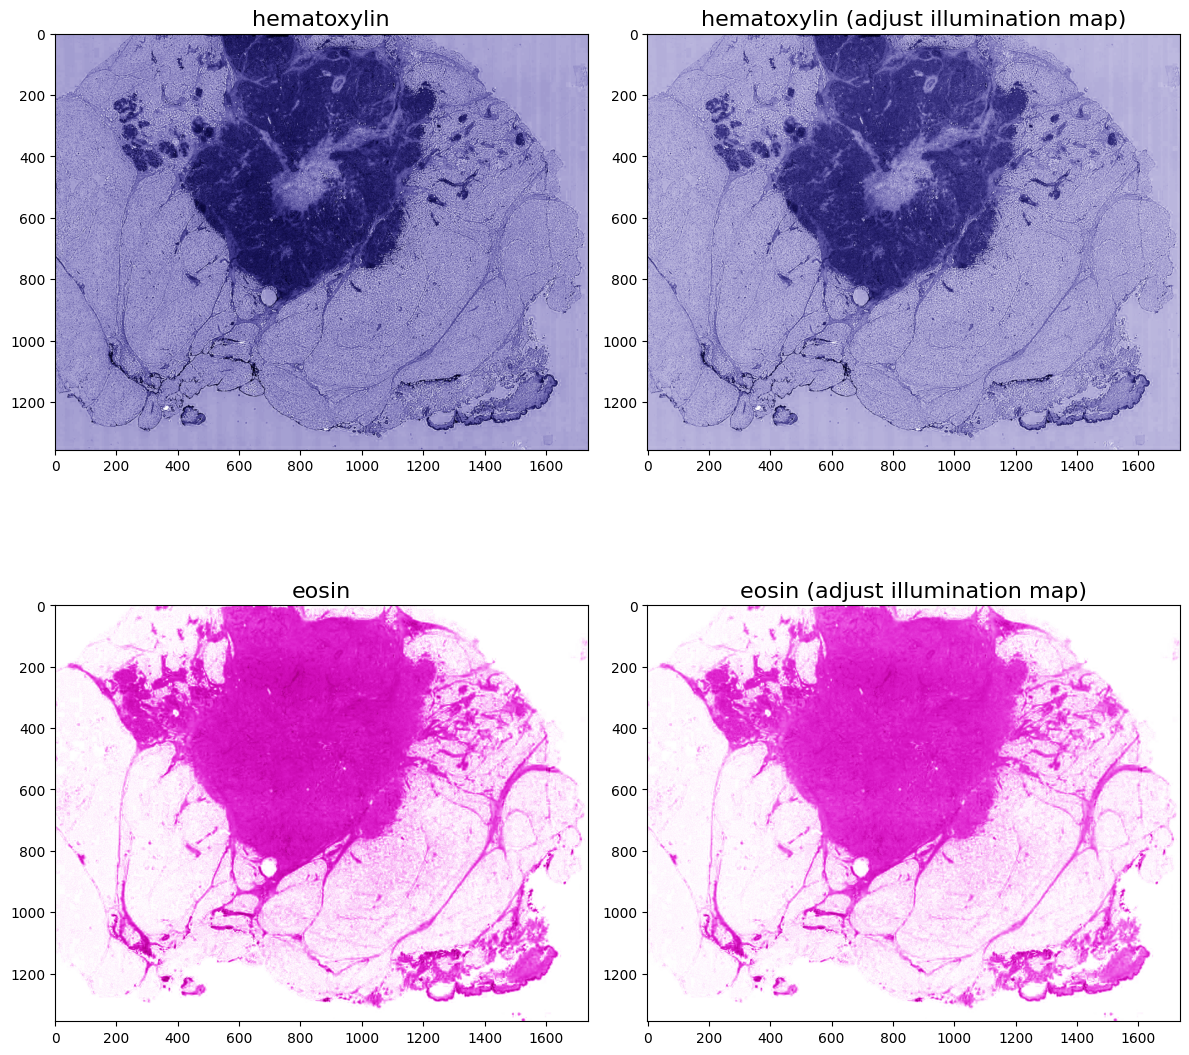

In [25]:
fontdict={
    "fontsize": 16
}

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
ax.imshow(hematoxylin)
ax.set_title(label="hematoxylin", fontdict=fontdict)

ax = fig.add_subplot(222)
ax.imshow(hematoxylin_adj)
ax.set_title(label="hematoxylin (adjust illumination map)", fontdict=fontdict)

ax = fig.add_subplot(223)
ax.imshow(eosin)
ax.set_title(label="eosin", fontdict=fontdict)

ax = fig.add_subplot(224)
ax.imshow(eosin_adj)
ax.set_title(label="eosin (adjust illumination map)", fontdict=fontdict)

fig.tight_layout()
plt.show()

### Recover

In [21]:
image_adj = stain_combine(stains_adj, stain_vector)

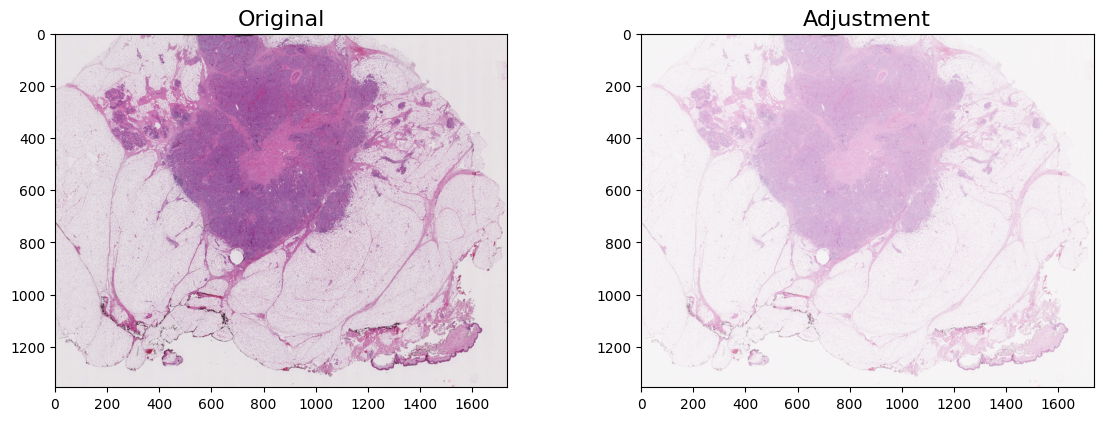

In [22]:
fontdict={
    "fontsize": 16
}

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(221)
ax.imshow(image)
ax.set_title(label="Original", fontdict=fontdict)

ax = fig.add_subplot(222)
ax.imshow(image_adj)
ax.set_title(label="Adjustment", fontdict=fontdict)

fig.tight_layout()
plt.show()